# Compute MSE between Ai-feynman estimated coefficients and exact coefficients

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

In [4]:
"""
Lotka-Volterra and Apoptosis model: 
    one input for t followed by a scaling layer; 2 
    hidden layers of 64 units for the surrogate 
    solution; 2 hidden layers of 16 units for the hidden 
    component approximation; sigmoid activation
"""

class ScalingLayer(nn.Module):
    def __init__(self, scale_init_value=1e-2, bias_init_value=0):
        super().__init__()
        self.scale = nn.Parameter(torch.FloatTensor([scale_init_value]))
        self.bias = nn.Parameter(torch.FloatTensor([bias_init_value]))

    def forward(self, input):
        return input * self.scale + self.bias
    
    
class U(nn.Module):
    def __init__(self, in_shape, out_shape, hidden_shapes):
        super().__init__()
        
        self.layers = nn.ModuleList()
        self.layers.append(ScalingLayer())
        for hidden in hidden_shapes:
            self.layers.append(nn.Linear(in_shape, hidden))
            self.layers.append(nn.Sigmoid())
            in_shape = hidden
        self.layers.append(nn.Linear(hidden_shapes[-1], out_shape))
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
class F(nn.Module):
    def __init__(self, in_shape, out_shape, hidden_shapes):
        super().__init__()
        
        self.layers = nn.ModuleList()
        for hidden in hidden_shapes:
            self.layers.append(nn.Linear(in_shape, hidden))
            self.layers.append(nn.Sigmoid())
            in_shape = hidden
        self.layers.append(nn.Linear(hidden_shapes[-1], out_shape))
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [3]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [25]:

def run(spacing, noise_level, f1_ai, f2_ai):
    spacing_list = ["0.1", "0.2", "0.3", "0.4", "0.5", "0.6"]
    noise_level_list = ["0", "0.1", "0.01", "0.03", "0.05", "0.08", "0.008"]
    if spacing not in spacing_list or noise_level not in noise_level_list:
        raise ValueError("Spacing or noise level not trained")

    # load model
    upinn = U(1, 2, [64,64])
    if noise_level == "0":
        upinn.load_state_dict(torch.load(f"../../upinn_models/LV/U_LV_exp2_sol_noise=0_space={spacing}.pt", map_location=DEVICE))
    else:
        upinn.load_state_dict(torch.load(f"../../upinn_models/LV/U_LV_exp2_sol_noise={noise_level}.pt", map_location=DEVICE))
    upinn.eval()
    
    t = torch.arange(0, 3, step=0.1).unsqueeze(1)

    xy = upinn(t)
    x, y = xy[:, 0].squeeze(), xy[:, 1].squeeze()

    loss1 = None
    loss2 = None
    if f1_ai is not None:
        loss1 = nn.MSELoss()(-0.9*x*y, x*y*f1_ai)
    if f2_ai is not None:
        loss2 = nn.MSELoss()(0.8*x*y, x*y*f2_ai)

    print(loss1.item() if loss1 is not None else None, loss2.item() if loss2 is not None else None)  

In [28]:
# run("0.1", "0", -0.895, 0.797)
# run("0.2", "0", -0.905, 0.812)
# run("0.3", "0", -0.906, 0.800)
# run("0.4", "0", -0.902, 0.802)
# run("0.5", "0", None, 0.803)
# run("0.6", "0", -0.902, 0.801)

run("0.1", "0.008", -0.908, None)
run("0.1", "0.01", None, 0.848)
run("0.1", "0.03", -0.911, None)
run("0.1", "0.05", -0.910, None)
run("0.1", "0.08", None, 0.857)
run("0.1", "0.03", None, None)

1.8122815163224004e-05 None
None 0.0006481666932813823
3.454262332525104e-05 None
2.942583705589641e-05 None
None 0.0009660599171184003
None None


## Test best found equation vs. selected equation vs correct equation
Let's consider the model trained on data with 0 noise and 0.1 spacing.

Ai Feynmann estimated as best fitting symbolic equation $-0.059618258747*(-((x1*x1)+(sqrt(x1)+1)))$ for F1 and $-0.059424679288+(x1*(sqrt(x1)*((-sqrt((x0+1)))+1)))$ for F2, where $x0 = x$ and $x1 = y$.

From the set of solutions, we select $0.895012887272*(x1*x0)$ for $F1$ and $0.796901691353*(x1*(-x0))$ for F2.

In [3]:
import math
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

In [73]:
def expression_ai_feynann(x, y):
    f1 = -0.059618258747*(-((y*y)+(torch.sqrt(y)+1)))
    f2 = -0.059424679288+(y*(torch.sqrt(y)*((-torch.sqrt((x+1)))+1)))
    return f1, f2

def expression_ai_feynann_selected(x, y):
    f1 = 0.895012887272*(y*x)
    f2 = 0.796901691353*(y*(-x))
    return f1, f2

In [74]:
def plot_estimated():
    DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    upinn = U(1, 2, [64,64])
    upinn.load_state_dict(torch.load(f"../../upinn_models/LV/U_LV_exp2_sol_noise=0_space=0.1.pt", map_location=DEVICE))
    upinn.eval()

    t = torch.linspace(0, 3, 1000).unsqueeze(1)
    xy = upinn(t)
    x, y = xy[:, 0].squeeze(), xy[:, 1].squeeze()

    f1_correct, f2_correct = 0.9*x*y, -0.8*x*y

    f1_ai, f2_ai = expression_ai_feynann(x, y)

    f1_ai_selected, f2_ai_selected = expression_ai_feynann_selected(x, y)

    ai_loss_1, ai_loss_2 = nn.MSELoss()(f1_correct, f1_ai).item(), nn.MSELoss()(f2_correct, f2_ai).item()

    ai_selected_loss_1,  ai_selected_loss_2 = nn.MSELoss()(f1_correct, f1_ai_selected).item(), nn.MSELoss()(f2_correct, f2_ai_selected).item()

    print("f1 MSE: {} {}".format(ai_loss_1, ai_selected_loss_1))
    print("f2 MSE: {} {}".format(ai_loss_2, ai_selected_loss_2))

    plt.plot(t, f1_correct.detach().numpy(), c='b', label='Correct equation', alpha=0.8, linewidth=0.8)
    plt.plot(t, f2_correct.detach().numpy(), c='b', alpha=0.8, linewidth=0.8)
    plt.plot(t, f1_ai.detach().numpy(), linestyle='--', c='r', label='Best AI Feynman equation', linewidth=0.7)
    plt.plot(t, f2_ai.detach().numpy(), linestyle='--', c='r', linewidth=0.7)
    plt.plot(t, f1_ai_selected.detach().numpy(), linestyle='-.', c='g', label='Selected equation', linewidth=0.9)
    plt.plot(t, f2_ai_selected.detach().numpy(), linestyle='-.', c='g', linewidth=0.9)
    plt.legend()
    # plt.savefig('example_sol.pdf')
    plt.show()


f1 MSE: 0.0024270322173833847 5.136605523148319e-06
f2 MSE: 0.00495554693043232 1.9826070456474554e-06


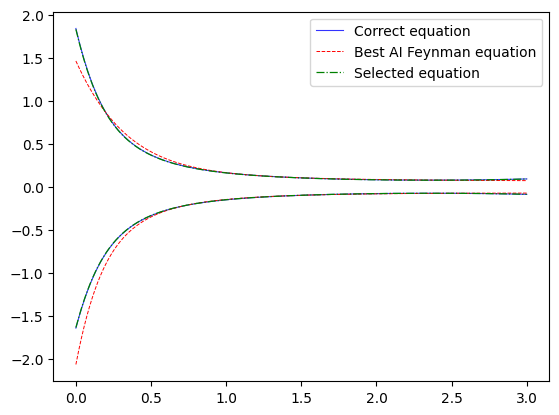

In [76]:
plot_estimated()